In [1]:
#!/usr/bin/python2.7

import sys
sys.path.insert(0, '/home/torobo/catkin_ws/src/torobo_robot/torobo_rnn/scripts')
sys.path.insert(0, '/home/torobo/catkin_ws/src/tutorial/PVRNN/scripts')

from enum import Enum
import random
from torobo_driver import torobo_easy_command
from termcolor import colored
import pickle

import os
import numpy as np
import rospy
import math
import matplotlib.pyplot as plt
from sensor_msgs.msg import Image
import ctypes
from utils2 import Utils
import utils2
from NRL import NRL
from collections import deque
import time
from torobo_operator import ToroboOperator
from torobo_rnn_utils__upd3 import *


sys.path.insert(0, '/home/torobo/catkin_ws/src/tutorial/PyTorch-YOLOv3')
from torobo_rnn_utils__upd3 import *
from detect_upd import Recog, Recog2
from scipy import signal
import scipy
from cv_bridge import CvBridge, CvBridgeError
import cv2


class NewRec(threading.Thread):

    """ RECORDS A DATASET FOR THE RNN """
    
    def __init__(self):
        threading.Thread.__init__(self)
        self.recording = False
        self.step = 0.1
        self.data = {}
    
    def run(self):
        if self.recording == True:
            self.recording = False
            print('Killing the previous recorder')
            time.sleep(1.5)
        self.recording = True
        self.record()
    
    def stop(self):
        self.recording = False
        time.sleep(1)
        print('Recording is {}'.format('ON' if self.is_alive() else 'OFF'))
        
        self.data['img'] = np.stack(self.data['img'])
        self.data['joints'] = np.stack(self.data['joints'])
        self.data['t'] = np.stack(self.data['t'])
        with open(self.fname, 'wb') as f:
            pickle.dump(self.data, f)
        print('Data saved')

        
    def record(self):
        global torobo, imagebuff
        print('Recording is {}'.format('ON' if self.is_alive() else 'OFF'))
        # overwrite
        if self.fname in os.listdir("."):
            open(self.fname, 'w').close()
        t = 0
        start_t = time.time()
        self.data['joints'] = []
        self.data['img'] = []
        self.data['t'] = []
        while self.recording:
            self.data['joints'].append(np.radians(get_cur_joints(torobo)[0]))
            self.data['img'].append(cv2.resize(imagebuff, (64,64), interpolation = cv2.INTER_AREA) )
            self.data['t'].append(time.time()-start_t)
            time.sleep(self.step)
            t += self.step
            

class Tracker(threading.Thread):
    """ - LOADS THE YOLO MODEL
        - FORWARD PASSES THE FRAME THROUGH THE MODEL
        - STORES BOUNDING BOX COORDINATES IN SELF.
    """
    
    def __init__(self):
        threading.Thread.__init__(self)
        
        checkpoint = 42
        self.recog = Recog2(checkpoint)
        self.box_cener = (0.0, 0.0)
        self.x1, self.y1, self.x2, self.y2 = 0.0, 0.0, 0.0, 0.0
        self.new_hor = 0
        self.new_ver = 0
        self.Norm = scipy.stats.norm(0, 20)
        self.scale = self.Norm.pdf(0)
        self.lasttime = 0.0
        
        self.keepgoing = False

    def stop(self):
        self.keepgoing = False
        print(colored('TRACKER STOPPED', 'white', 'on_red'))

    def get_gaze_offset(self, cx, cy):
        return 640/2 - cx, 480/2 - cy
    
    def get_gaze_grad(self, offset_x, offset_y):
        ex = 0.2 * np.tanh(0.025*(offset_x))/ (1+self.Norm.pdf(offset_x)/self.scale*4)
        ey = 0.2 * np.tanh(0.025*(offset_y))/ (1+self.Norm.pdf(offset_x)/self.scale*4)
        return ex, ey

    def get_box_center(self, x1, y1, box_w, box_h):
        self.box_cener = (x1 + box_w/2, y1 + box_h/2)
        return x1 + box_w/2, y1 + box_h/2

    def track_obj(self, x,y,w,h):
        global torobo
        cx, cy = self.get_box_center(x, y, w, h)
        gaze_offset = self.get_gaze_offset(cx,cy)
        ex, ey = self.get_gaze_grad(*gaze_offset)
        hor, ver = get_cur_joints(torobo)[0][14:16]
        self.new_hor, self.new_ver = np.radians(hor)+ex, np.radians(ver)-ey
#         self.move()
        
    def move(self):
        """ you can move the head from here, but it's glitchy """
        global torobo
        if time.time() - self.lasttime > 0.2:
            self.lasttime = time.time()
            hor, ver = self.new_hor, self.new_ver
            try:
                torobo.move_joint_my (controller_id=ToroboOperator.TORSO_HEAD,
                                      joint_ids = [0, 1, 2, 3],
                                      positions=[0, np.radians(38.0), hor, ver],
                                      velocities=None,
                                      accelerations=None,
                                      duration=0.2)
            except:
                print('catching exception')
        else:
            pass       

    def run(self):
        global imagebuff
        self.keepgoing = True
        while True and self.keepgoing:
            detections = self.recog.detect(imagebuff)
#             time.sleep(0.025)
            if detections is not None:
                for det in detections:
                    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                        if cls_pred == 0:
                            box_w = x2 - x1
                            box_h = y2 - y1
                            self.x1, self.y1, self.x2, self.y2 = x1, y1, x2, y2
                            x, y, w, h = x1, y1, box_w, box_h
                            self.track_obj(x, y, w, h)



def to_radians(input_data):
    data=input_data
    for i in range(data.shape[0]):
    #pos_list=data[i]
        for j in range(len(data[i])):
            data[i][j]=math.radians(data[i][j])
    return data

def model_to_radians(input_data):
    for i in range(len(input_data)):
        input_data[i]=math.radians(input_data[i])
    return input_data


class ExtForce(object):
    # SETS THE KINEMATIC MODEL PARAMETERS (BOTH IN HENDRY'S AND FACTORY FIRMWARE)

    class Mode(Enum):
        Teaching = 0
        Experiment = 1

    def runCommands(self, _commandList, _controller):
          for command in _commandList:
                torobo_easy_command.SendEasyCommandText(_controller, command)
                rospy.sleep(0.01)

    def registerParameters(self, tau_th, kp, sum_e_max, d, kr, theta_th):
            # left and right arm 
            for i in range(0,6):
                
                # constructing the commands for the left arm
                commandList = []				
                commandList.append("param " + str(i+1) + " fftauth " +       str(tau_th[i]))
                commandList.append("param " + str(i+1) + " ffkp " +          str(kp[i]))
                commandList.append("param " + str(i+1) + " ffsigmaemax " +   str(sum_e_max[i]))
                commandList.append("param " + str(i+1) + " ffdamping " +     str(d[i]))
                commandList.append("param " + str(i+1) + " ffkr " +          str(kr[i]))
                commandList.append("param " + str(i+1) + " softki " +        str(theta_th[i]))	


                # send to execution
                self.runCommands(commandList, "left_arm_controller")

            # right arm 
            for i in range(0,6):
                ii = i + 6 
                # constructing the commands for the right arm
                commandList = []
                commandList.append("param " + str(i+1) + " fftauth " +       str(tau_th[ii]))
                commandList.append("param " + str(i+1) + " ffkp " +          str(kp[ii]))
                commandList.append("param " + str(i+1) + " ffsigmaemax " +   str(sum_e_max[ii]))
                commandList.append("param " + str(i+1) + " ffdamping " +     str(d[ii]))
                commandList.append("param " + str(i+1) + " ffkr " +          str(kr[ii]))
                commandList.append("param " + str(i+1) + " softki " +        str(theta_th[ii]))	

                # send to execution
                self.runCommands(commandList, "right_arm_controller")
                            
            for i in range(0,4):
                ii = i + 12 
                # constructing the commands for the head-torso chain
                commandList = []				
                commandList.append("param " + str(i+1) + " fftauth " +       str(tau_th[ii]))
                commandList.append("param " + str(i+1) + " ffkp " +          str(kp[ii]))
                commandList.append("param " + str(i+1) + " ffsigmaemax " +   str(sum_e_max[ii]))
                commandList.append("param " + str(i+1) + " ffdamping " +     str(d[ii]))
                commandList.append("param " + str(i+1) + " ffkr " +          str(kr[ii]))
                commandList.append("param " + str(i+1) + " softki " +        str(theta_th[ii]))	

                # send to execution
                self.runCommands(commandList, "torso_head_controller")


    def __init__(self, _mode):	
        
        if _mode == ExtForce.Mode.Teaching:

            tau_th = [2.0, 2.0, 1.0, 1.0, 0.5, 0.5,            2.0, 2.0, 1.0, 1.0, 0.5, 0.5,      20.5, 20.5, 20.5, 20.5]
            kp = [0.1, 0.1, 0.05, 0.05, 0.1, 0.1,            0.1, 0.1, 0.05, 0.05, 0.1, 0.1,        0.0,0.0,0.0,0.0]
            sum_e_max = [200.0,200.0,100.0,100.0,50.0,50.0,  200.0,200.0,100.0,100.0,50.0,50.0,   200.0,200.0,50.0,50.0]
            d = [0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9]
            # kr = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
            kr = [0.1]*16
            kr[5] = 0.3
            kr[11] = 0.3
            theta_th = [1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57]
            theta_th = [i*1.63 for i in theta_th]

            self.registerParameters( tau_th, kp, sum_e_max, d, kr, theta_th)


        elif _mode == ExtForce.Mode.Experiment:

            tau_th = [12.0,12.0,5.0,5.0,1.5,1.5,12.0,12.0,5.0,5.0,1.5,1.5,200.0,200.0,200.0,200.0]
            kp = [0.025,0.025,0.05,0.05,0.1,0.1,0.025,0.025,0.05,0.05,0.1,0.1,0.025,0.025,0.05,0.05]
            sum_e_max = [200.0,200.0,100.0,100.0,50.0,50.0,200.0,200.0,100.0,100.0,50.0,50.0,200.0,200.0,50.0,50.0]
            d = [0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9]
            kr = [0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
            # kr = [0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9]
            theta_th = [1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57]
            theta_th = [i*1.63 for i in theta_th]

            self.registerParameters( tau_th, kp, sum_e_max, d, kr, theta_th)
            

class Trial():
    def __init__(self, prop_path, primId):
        self.nrl = NRL()
        self.cwd = os.getcwd()
        self.ut = Utils(self.cwd)
        self.nZ = '4,1'
        self.nD = '40,10'             
        #nZ = '4,2,1'
        #nD = '40,20,10'
        self.nrl.newModel(prop_path.encode('ascii'))
        self.nrl.load()
        self.nDof = self.nrl.getNDof()
        self.stateBufferSize = self.nrl.getStateBufferSize(self.nD, self.nZ, self.ut.delimiter)
        if self.nDof > 0:
            winSize = 15 # not used in Prior Generation mode
            winBufferSize = winSize * self.nDof
            winBuffdata = deque(maxlen=winSize) # circular buffer

            # The e_w parameters set bellow assume the network has two layers
            # as in the original distribution of the sources
            # in case more layers are set by changing the properties.d file,
            # the same dimension for e_w must be considered
            e_w = [0.025,0.025]
            self.start = False

            expTimeSteps = 30
            postdiction_epochs = 15
            alpha = 0.1
            beta1 = 0.9
            beta2 = 0.999
            storeStates = False
            storeER = False
            showERLog = False
            self.nrl.e_enable(primId,
                         winSize,
                         (ctypes.c_float * len(e_w))(*e_w),
                         expTimeSteps, # set to zero if you want to make primId irrlevant
                         postdiction_epochs,
                         (ctypes.c_float)(alpha),
                         (ctypes.c_float)(beta1),
                         (ctypes.c_float)(beta2), 
                         storeStates, 
                         storeER)

    def generate_pos(self):
        self.tgt_pos_buffer = np.zeros((self.nDof,), dtype=float)
        dataOut = (ctypes.c_float * self.nDof)(*self.tgt_pos_buffer)
        self.stateBufferSize = self.nrl.getStateBufferSize(self.nD, self.nZ, self.ut.delimiter)
        self.nrl.e_generate(dataOut)
        self.tgt_pos = np.frombuffer(dataOut, np.float32)
        return self.tgt_pos

    
    
def gostart(torobo):
    """ GO TO STARTING POSITION """
    idx = 4
    TIME = 5
    try:
        with HiddenPrints():
            servo_on(torobo)
            set_softness_override(torobo, 10.0)
            set_velocity_override(torobo, 10.0)
            with open('rad.pickle', 'rb') as f:
                RAD = pickle.load(f)

            left_arm_positions = RAD[idx][0:6]
            right_arm_positions = RAD[idx][6:12]
            torso_head_positions = RAD[idx][12:16]

            torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
            torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
            torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
            rospy.sleep(TIME+0.1)
        print(colored('SUCCESS', 'white', 'on_green'))
    except:
        print('ERROR')
    

def setModeOverrides(torobo):
    """SET THE NEEDED KINEMATIC PARAMETERS AND MODES, OVERRIDES ON THE RIGHT JOINTS"""
    print('SETTING MODE: set_external_force_following_online_trajectory_control')
    with HiddenPrints():
        set_external_force_following_online_trajectory_control(torobo)
        torobo.set_control_mode(ToroboOperator.TORSO_HEAD, ['torso_head/joint_1',
                                                            'torso_head/joint_2'],
                                'position')
    print('SETTING DYNAMIC PARAMETERS')
    with HiddenPrints():
        time.sleep(1)
        ExtForce(ExtForce.Mode.Teaching)
        time.sleep(1)
    print('OVERRIDES SET')
    with HiddenPrints():
        set_softness_override(torobo, 10.0)
        set_velocity_override(torobo, 10.0)
        
torobo = ToroboOperator()

# start video publisher

if not 'bridge' in locals():
    bridge = CvBridge()
if not 'torobo' in locals():
    torobo = ToroboOperator()
if not 'imagebuff' in locals():
    imagebuff = 0
    def image_callback(msg):
        global imagebuff
        imagebuff = bridge.imgmsg_to_cv2(msg, "rgb8") 
    rospy.Subscriber("/camera/color/image_raw", Image, image_callback)
    time.sleep(0.5)
    print(colored('VIDEO FEED STARTED', 'blue', 'on_yellow'))
else:
    print(colored('VIDEO FEED ALREADY RUNNING', 'blue', 'on_yellow'))

VIDEO FEED STARTED


In [2]:
# CALIBRATE THE TABLE POSTION
gostart(torobo)

if not 'imagebuff' in locals():
    imagebuff = 0
    def image_callback(msg):
        global imagebuff
        imagebuff = bridge.imgmsg_to_cv2(msg, "rgb8") 
    rospy.Subscriber("/camera/color/image_raw", Image, image_callback)

cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

while True:
    cv2.imshow('I see', cv2.cvtColor(imagebuff, cv2.COLOR_RGB2BGR))
    k = cv2.waitKey(3) & 0XFF
    if k== 27 :
        cv2.destroyWindow('I see')
        break

SUCCESS


In [8]:
setModeOverrides(torobo)
gostart(torobo)

SETTING MODE: set_external_force_following_online_trajectory_control
SETTING DYNAMIC PARAMETERS
OVERRIDES SET
SUCCESS


In [9]:
# GENERATION OF PRIOR

prop_path = "/home/torobo/catkin_ws/src/tutorial/src/data/config/modxp2.d"
# prop_path = "/home/torobo/catkin_ws/src/tutorial/src/data/config/modxp_long.d"


primId = 2
print(colored('PRIMITIVE ID: {}'.format(primId), 'red', 'on_blue', attrs=['bold']))

model = Trial(prop_path, primId)

tracker = Tracker()
tracker.start()
time.sleep(1)


data_rec = NewRec()
data_rec.fname = 'prior_gen_w_head_tracking.dat'
data_rec.start()

INTERVAL = 0.10

model_list = []
model_data = np.array(model.generate_pos())

exceptionCount = 0
while True:
    try:
        full_cor = np.array(model.generate_pos())
        time.sleep(INTERVAL)
        left_cor = np.radians(full_cor[0:6])
        right_cor = np.radians(full_cor[6:12])
    #         torobo.move(ToroboOperator.LEFT_ARM, positions=left_cor, duration=INTERVAL)
    #         torobo.move(ToroboOperator.RIGHT_ARM, positions=right_cor, duration=INTERVAL)
        torso_cor = np.array([0, np.radians(38.0), tracker.new_hor, tracker.new_ver], dtype='float')
        tgt_pos_16 = np.degrees(np.concatenate([left_cor, right_cor, torso_cor]))
        move_pos_whole_body(torobo, tgt_pos_16, np.zeros((16,)))
    except:
        print(colored('user interrupt', 'red', 'on_yellow', attrs=['bold']))
        break
        
tracker.stop()
data_rec.stop()

PRIMITIVE ID: 2
Recording is ON
user interrupt
TRACKER STOPPED
Recording is OFF
Data saved


In [17]:
tracker.stop()

TRACKER STOPPED


In [4]:
with open('prior_gen_w_head_tracking.dat', 'rb') as f:
    dat = pickle.load(f)

with open('RAD{}_w_head_tracking.dat'.format(primId), 'rb') as f:
    dat1 = pickle.load(f)
    

(-1.7, 2)

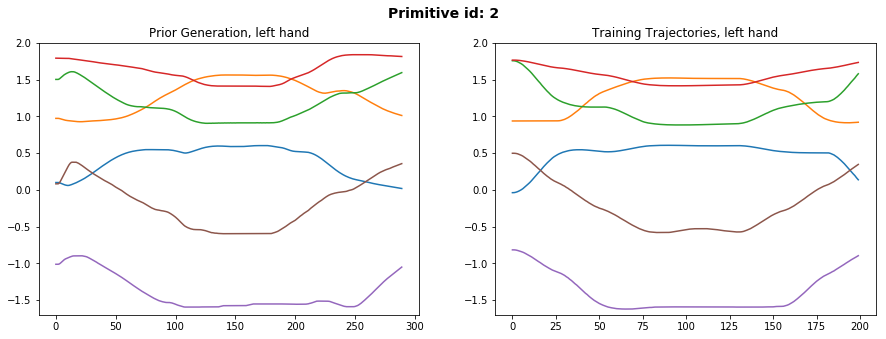

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('Primitive id: {}'.format(primId), fontsize=14, weight='bold')
plt.title('Prior Generation, left hand')
plt.plot(dat['joints'][:290,:6])
plt.ylim(-1.7, 2)
plt.subplot(1,2,2)
plt.title('Training Trajectories, left hand')
plt.plot(dat1['joints'][:200,:6])
plt.ylim(-1.7, 2)